# Lab 7: Raster Statistics and Raster Time Series

In this lab, we will analyze seasonal variations in vegetation across Prince George public parks using Sentinel-2 imagery. Specifically, we will:

1. Calculate the Normalized Difference Vegetation Index (NDVI) for each season.

2. Perform zonal statistics to compute seasonal NDVI for specific regions using a shapefile of parks.

3. Aggregate these zonal statistics by season.

4. Generate a time series of NDVI maps to visualize changes over time.

5. Export an animated GIF of NDVI maps across seasons.

## Overview of Sentinel-2 bands:

| Sentinel-2 Bands              | Central Wavelength (µm) | Resolution (m)^ |
|-------------------------------|-------------------------|----------------|
| Band 1 - Coastal aerosol      | 0.443                  | 60             |
| Band 2 - Blue                 | 0.490                  | 10             |
| Band 3 - Green                | 0.560                  | 10             |
| Band 4 - Red                  | 0.665                  | 10             |
| Band 5 - Vegetation Red Edge  | 0.705                  | 20             |
| Band 6 - Vegetation Red Edge  | 0.740                  | 20             |
| Band 7 - Vegetation Red Edge  | 0.783                  | 20             |
| Band 8 - NIR                  | 0.842                  | 10             |
| Band 8A - Vegetation Red Edge | 0.865                  | 20             |
| Band 9 - Water vapour         | 0.945                  | 60             |
| Band 10 - SWIR - Cirrus       | 1.375                  | 60             |
| Band 11 - SWIR                | 1.610                  | 20             |
| Band 12 - SWIR                | 2.190                  | 20             |

*^Note: All bands have been resampled to 20m for this lab.*

In [1]:
# Preamble
import os
import numpy as np
import rasterio as rio
from rasterio.transform import array_bounds
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats

## Loading and Processing Rasters

We begin by reading in four seasonal Sentinel-2 images stored as GeoTIFF files at 20 m resolution. Each image contains multiple bands, and we will extract the necessary bands to compute NDVI as we did in Lab 6.

In [3]:
# Folder containing the seasonal raster files
raster_folder = 'data/seasons/'

# Get a list of all .tif files in the folder
raster_files = [f for f in os.listdir(raster_folder) if f.endswith('.tif')] #adds the file name to the list for each file ending in .tif
print(raster_files)

['S2_Spring_2024-04-19.tif', 'S2_Summer_2024-07-21.tif', 'S2_Fall_2023-10-27.tif', 'S2_Winter_2024-12-23.tif']


Notice that all have the same naming convention: `S2_Season_Year-Month-Day`

In [8]:
# Dictionary to store NDVI and associated info for each season
ndvi_dict = {}

for raster_file in raster_files:
    # Extract the season (the second underscore-delimited element)
    season = raster_file.split('_')[1]
    raster_path = os.path.join(raster_folder, raster_file)
    
    with rio.open(raster_path) as src:
        # Read red and NIR bands (rasterio uses 1-indexing)
        # print(src.read().dtype) # original dtype is uint16
        red = src.read(4).astype('float32') #This gives us 24 total significant bits to use for our values
        nir = src.read(8).astype('float32')
        
        # Calculate NDVI
        ndvi = (nir - red) / (nir + red)
        
        # Save the NDVI array along with the affine transform needed for zonal stats
        ndvi_dict[season] = {
            'ndvi': ndvi,
            'affine': src.transform,
            'meta': src.meta.copy()
        }
        
        print(f"Processed NDVI for season: {season}")

Processed NDVI for season: Spring
Processed NDVI for season: Summer
Processed NDVI for season: Fall
Processed NDVI for season: Winter


/var/folders/72/l9rb7pj53xqd9y12z7w93q9c0000gp/T/ipykernel_64521/543101139.py:16: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


### Quick exercise:
Split the raster file name at different sections of the file path name by changing the bracketted number above. Note how we index the position of each element in the file name. Change back to [1] in brackets and run the code block before proceeding. 

**Code breakdown:**

`RuntimeWarning: invalid value encountered in divide`
- This warning indicates that during the NDVI calculation, some operations resulted in an invalid value, probably when trying to divide by zero.
- Sometimes, certain pixels might be flagged as no-data. In this case, we have a small number of `NaNs`, that do not affect our overall analysis, so we can ignore the error.

What does the `os` module do?
- This module is part of Python's standard library and acts as a way of using operating system-dependent (i.e. Mac, Windows, Linux) functionality.
- Here, `os.listdir()` is used to list all files in the specified `raster_folder` and `os.path.join()` is used to correctly build full file paths.

What information are we storing in `ndvi_dict` and why?
- Organizing NDVI data by season (`ndvi_dict[season]`) makes it easier to loop through them for further analysis or visualization.
- `'ndvi': ndvi` stores the calculated NDVI values for each pixel.
- `'affine': src.transform` converts pixel coordinates into spatial (geographic) coordinates. It’s critical for mapping and overlaying the NDVI data onto a map.
- `'meta': src.meta.copy()` contains additional information about the raster such as its coordinate reference system (CRS), dimensions (width, height), data type, etc.

Why must we convert the bands to `float32`?
- This ensures that the NDVI values are accurately computed and that subsequent analyses (such as calculating means or medians) use the correct values.
- Many remote sensing operations (like NDIs) expect floating-point arithmetic because the resulting indices typically range between -1 and 1 with decimal values.

Let's look at one of the seasonal NDVI arrays we have created:

In [21]:
ndvi_dict['Fall']

{'ndvi': array([[       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [0.06039216, 0.03405449, 0.02349129, ...,        nan,        nan,
                nan],
        ...,
        [       nan, 0.15922228, 0.13833058, ...,        nan,        nan,
                nan],
        [       nan, 0.11764706, 0.13657694, ...,        nan,        nan,
                nan],
        [       nan, 0.1406921 , 0.1784831 , ...,        nan,        nan,
                nan]], dtype=float32),
 'affine': Affine(20.0, 0.0, 511560.0,
        0.0, -20.0, 5978480.0),
 'meta': {'driver': 'GTiff',
  'dtype': 'uint16',
  'nodata': None,
  'width': 623,
  'height': 629,
  'count': 12,
  'crs': CRS.from_epsg(32610),
  'transform': Affine(20.0, 0.0, 511560.0,
         0.0, -20.0, 5978480.0)}}

We see that it contains the NDVI calculations and metadata, including affine transformation type, necessary for plotting in geographic space.

## Zonal Statistics

We now calculate summary NDVI statistics for each season within Prince George public park boundaries using a geopackage. (Source: [Prince George Open Data](https://data-cityofpg.opendata.arcgis.com/))

First, let's use `GeoPandas` to read our vector geopackage, reproject to the raster's CRS, and plot a preview:

In [10]:
# Load the parks shapefile (update the path as needed)
parks_shapefile = 'data/PG_ParkData.gpkg'
parks = gpd.read_file(parks_shapefile)

# Check the CRS of the parks shapefile
print(parks.crs)

# Reproject parks to match the raster's CRS (EPSG:32610)
parks = parks.to_crs('EPSG:32610')
print(parks.crs)

# Test if the CRS of the parks shapefile matches the rasters
parks.crs == ndvi_dict['Summer']['meta']['crs']

EPSG:26910
EPSG:32610


True

<Axes: >

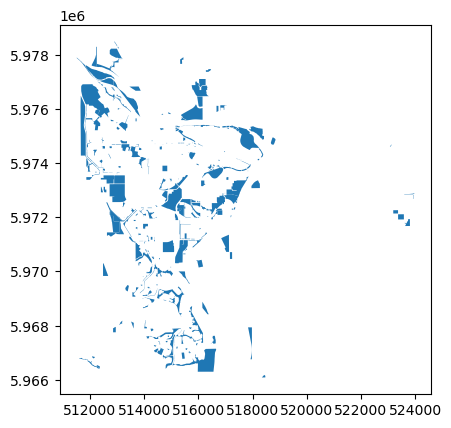

In [11]:
parks.plot()

### Side quest 

What is the `location` of the largest and smallest park according to the shapefile?

*Note: this shapefile has been clipped to our ROI*

In [12]:
parks.columns

Index(['AssetID', 'FacilityID', 'LifeCycleStatus', 'SubType', 'AssetOwner',
       'AssetManager', 'Location', 'InstallDate', 'OperationalArea',
       'ParkName', 'Developed', 'TurfedArea_sqm', 'TreedArea_sqm',
       'OtherArea_sqm', 'Weblink', 'Accessibility', 'ConditionDate',
       'AcquistionCost', 'created_user', 'created_date', 'last_edited_user',
       'last_edited_date', 'SubType_TEXT', 'ServiceLevel', 'Image_Hyperlink',
       'ParkClassification', 'Condition', 'CoFScore', 'CoFDate', 'RiskScore',
       'Link', 'GlobalID', 'geometry'],
      dtype='object')

We have lots of columns, but we are interested in utilizing only `Location` and `geometry`:

In [8]:
# Calculate the area of each park using its stored geometry in square meters and save as a new column
parks['area'] = parks.geometry.area

# Find the location of the largest and smallest parks
loc1 = parks['area'].idxmax()
loc2 = parks['area'].idxmin()

# Print the indexed row of the largest and smallest parks
print(loc1)
print(loc2)

# Extract the largest and smallest parks
largest_park = parks.loc[loc1]
smallest_park = parks.loc[loc2]

# Print the largest and smallest parks with their location and area
print("\nLargest Park:")
print(largest_park[['Location', 'area']])

print("\nSmallest Park:")
print(smallest_park[['Location', 'area']])

277
128

Largest Park:
Location    McMillan Creek Regional Park
area                       600853.993302
Name: 277, dtype: object

Smallest Park:
Location    4244 Jackson Cres
area                  61.5459
Name: 128, dtype: object


**Code breakdown:**

Why not use `parks['area'].min()` and `.max()` functions?
- `max()` and `min()` would return the actual maximum or minimum value, but they don’t tell us which row contains these values, which is where `idxmax()` and `idxmin()` come in handy.

Why use double brackets `[['Location', 'area']]`?
- The double brackets are used to select multiple columns from a geopandas GeoDataFrame.

### Compute Zonal Statistics for Each Season
- We loop over each season in the `ndvi_dict`. For each season, we calculate zonal statistics (mean and median) for all parks in the shapefile.

- The `'affine'` transformation is used to align the NDVI raster with the park boundaries. The affine transformation converts raster pixel coordinates to geospatial coordinates based on the raster's CRS.

- We use `nodata=np.nan` so that any missing values (i.e., if part of the vector extends beyond the raster) are ignored in the calculations.

In [13]:
zonal_stats_dict = {}  # This dictionary will store zonal statistics for each season

for season, data in ndvi_dict.items():
    stats = zonal_stats(
        parks, # GeoDataFrame containing park boundaries
        data['ndvi'], # NDVI array for the current season
        affine=data['affine'], # Affine transformation for the raster
        stats=['mean', 'median'], # Calculate both mean and median NDVI
        nodata=np.nan # Treat no data values as NaN
    )
    
    zonal_stats_dict[season] = stats

Let's look at the dictionary we have created:

In [14]:
zonal_stats_dict.items()

dict_items([('Spring', [{'mean': 0.20387097767421178, 'median': 0.2014232575893402}, {'mean': 0.24607079823811848, 'median': 0.2480638027191162}, {'mean': 0.32097853769675394, 'median': 0.3787105977535248}, {'mean': 0.18746322024185047, 'median': 0.18517303466796875}, {'mean': 0.20074784286378874, 'median': 0.18191717565059662}, {'mean': 0.2526686397599585, 'median': 0.24668830633163452}, {'mean': 0.16757652976296164, 'median': 0.1805618852376938}, {'mean': 0.28986258359299494, 'median': 0.2669726312160492}, {'mean': 0.08268667757511139, 'median': 0.08268667757511139}, {'mean': 0.08372287452220917, 'median': 0.06602191925048828}, {'mean': 0.16581549644470214, 'median': 0.1657831370830536}, {'mean': 0.1804322600364685, 'median': 0.17777399718761444}, {'mean': 0.07953007022539775, 'median': 0.07551533728837967}, {'mean': 0.0756230782239865, 'median': 0.05670446902513504}, {'mean': 0.09663765132427216, 'median': 0.09232811629772186}, {'mean': 0.2774379544141816, 'median': 0.28341653943061

We have Mean and Median NDVI values stored for each park and for each season. Since we have so many shapes/parks storing this data, it's difficult to parse any meaningful trends. Aggregating the statistics by computing the overall mean and median for each season will make understanding fluctations between seasons much easier.

### Aggregate the Zonal Statistics

- For each season, we aggregate the per-park statistics into overall values. This is done by calculating the mean and median of all the park means and medians for each season. 

- We filter out any None values to ensure our calculations are accurate. 
    - What happens if we do not filter out the None values? 
        - Returns the error: `unsupported operand type(s) for +: 'float' and 'NoneType'` noting inability to calculate when `NaNs`/`NoneTypes` are present.

In [16]:
season_mean_ndvi = {} # Dictionary to store overall mean NDVI per season
season_median_ndvi = {} # Dictionary to store overall median NDVI per season

# This unpacks the dictionary into its key-value pairs (season = season and stats = mean/median NDVI)
for season, stats in zonal_stats_dict.items(): 
    # Extract the mean values from each park
    means = [stat['mean'] for stat in stats 
             if stat['mean'] is not None]
    
    # Extract the median values from each park
    medians = [stat['median'] for stat in stats 
               if stat['median'] is not None]
    
    # Compute the overall mean NDVI for the season
    season_mean_ndvi[season] = np.mean(means) 
    # Compute the overall median NDVI for the season
    season_median_ndvi[season] = np.median(medians)

    # Print the aggregated results for this season
    print(f"{season} - Mean NDVI: {season_mean_ndvi[season]:.3f}, Median NDVI: {season_median_ndvi[season]:.3f}")

Spring - Mean NDVI: 0.211, Median NDVI: 0.213
Summer - Mean NDVI: 0.362, Median NDVI: 0.389
Fall - Mean NDVI: 0.219, Median NDVI: 0.225
Winter - Mean NDVI: 0.074, Median NDVI: 0.046


### Visualizing Aggregated Zonal Statistics

#### Line Plot

Using the aggregated data we can now make a simple line plot that illustrates how NDVI changes from season to season:

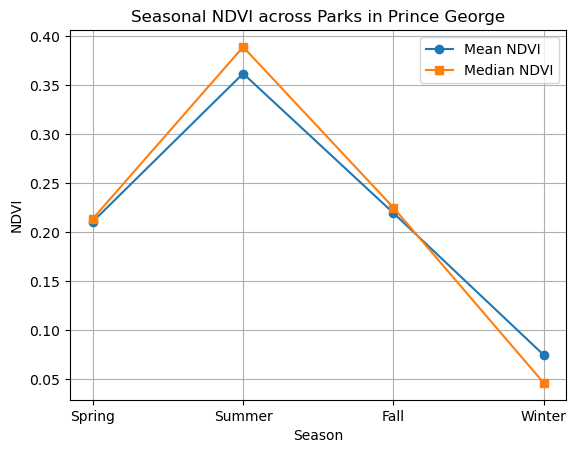

In [17]:
seasons = ndvi_dict.keys() # Extract season names for plotting on x-axis
mean_values = [season_mean_ndvi[s] for s in seasons] # For loop to extract means for each season
median_values = [season_median_ndvi[s] for s in seasons] # For loop to extract medians for each season

# Create a timeseries plot for NDVI across seasons
plt.figure()
plt.plot(seasons, mean_values, marker='o', label='Mean NDVI')
plt.plot(seasons, median_values, marker='s', label='Median NDVI')
plt.xlabel('Season')
plt.ylabel('NDVI')
plt.title('Seasonal NDVI across Parks in Prince George')
plt.legend()
plt.grid(True)

#### Map Time Series

Next, we will plot each seasonal NDVI array as a map and overlay the park shapefile to see where our NDVI values are being sourced: 

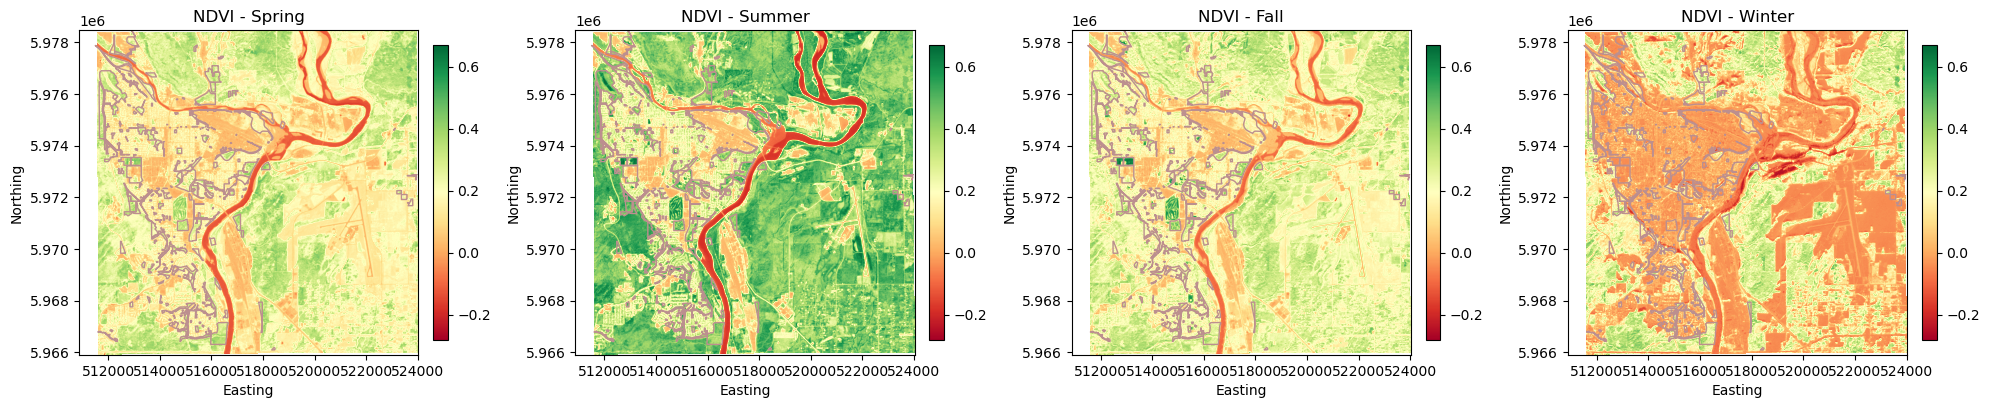

In [19]:
# Create a figure with subplots for each season
fig, axs = plt.subplots(1, 4, figsize=(20, 10))

# Define the global min and max NDVI values for consistent colour scaling among all four maps
# nanmin/nanmax ignores nans when computing min/max values
ndvi_min = min(np.nanmin(ndvi_dict[season]['ndvi']) for season in seasons)
ndvi_max = max(np.nanmax(ndvi_dict[season]['ndvi']) for season in seasons)

# Use a loop to retrieve the NDVI data and affine transformation for the current season from ndvi_dict
# This loop iterates over each subplot axis (ax) 
for ax, season in zip(axs, seasons):
    data = ndvi_dict[season]
    ndvi = data['ndvi']
    affine = data['affine']
    
    # Compute spatial bounds from the NDVI array dimensions and the affine transform
    nrows, ncols = ndvi.shape # ndvi.shape gives the number of rows and columns in the NDVI raster
    left, bottom, right, top = array_bounds(nrows, ncols, affine) # array_bounds() uses the affine transformation to convert pixel dimensions into real-world spatial coordinates
    extent = [left, right, bottom, top] # used to properly align the image on the map
    
    # Plot the NDVI map
    im = ax.imshow(ndvi, cmap='RdYlGn', extent=extent, vmin=ndvi_min, vmax=ndvi_max) # Plots the NDVI array using the 'RdYlGn' colormap at the correct geographic extent
    ax.set_title(f"NDVI - {season}") # Iterates over each subplot and sets the title to the current season
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    
    # Overlay parks boundaries
    parks.boundary.plot(ax=ax, edgecolor='rosybrown', linewidth=1)
    
    # Add a colorbar for each subplot
    plt.colorbar(im, ax=ax, fraction=0.04, pad=0.04) # The fraction and pad parameters control the size and spacing of the colorbar relative to the plot

plt.tight_layout() # Adjusts the spacing between subplots to ensure that labels, titles, and colorbars don't overlap

**Code breakdown:** How does the `zip()` function in Python work?

- It is used to combine multiple iterables (like lists or tuples) element by element. It returns an iterator that pairs corresponding elements together into tuples.

**Why are we using `zip()` in this instance?**

1. We have a list of subplots (`axs`)

    - When using `plt.subplots(1, 4)`, it returns a list of 4 subplot axes (`axs`), one for each season.

2. We have a list of season names (`seasons`)

    - This list contains the names of the four seasons in a known order.

3. We need to map each season to a specific subplot

    - Each subplot (`ax`) should display the NDVI for a different season. `zip(axs, seasons)` lets us loop through both lists simultaneously.

##### Creating a GIF of the Map Time Series

To create a gif we will import two new packages:

1. `imageio` (version 2): a Python library designed for reading and writing a wide range of image data formats. 
    - It can handle various formats (PNG, JPEG, GIF, etc.), which is useful for processing images, such as reading plots from a buffer and saving them as an animated GIF.

2. `io`: This module is part of Python's standard library and provides tools for handling input and output operations. One of its most commonly used features is the `BytesIO` class.
    - `BytesIO` allows us to work with data (like images) in memory, as if it were a file, without needing to write it to disk. This is especially useful when you want to quickly create and process images without creating temporary files.

3. `IPython.display`: This contains functions `Image` and `display` needed to display the GIF inline

In [20]:
import imageio.v2 as imageio
import io
from IPython.display import Image, display

In [29]:
# List to store each image frame of the GIF
frames = []

# For each season, the NDVI array and its corresponding affine transformation are extracted from ndvi_dict
for season in seasons: # We previously defined seasons as the list of seasons in the ndvi_dict dictionary
    data = ndvi_dict[season]
    ndvi = data['ndvi']
    affine = data['affine']
    
    # Calculate spatial bounds using raster dimensions and affine transform
    nrows, ncols = ndvi.shape
    left, bottom, right, top = array_bounds(nrows, ncols, affine)
    extent = [left, right, bottom, top]
    
    # Create figure and plot NDVI. These figures are stored as frames for the gif.
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(ndvi, cmap='RdYlGn', extent=extent, vmin=ndvi_min, vmax=ndvi_max)
    ax.set_title(f"NDVI - {season}")
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")
    
    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('NDVI')

    # Save figure to a bytes buffer. This saves the current figure in the loop as an image in memory without writing it to disk.
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    
    # Read the image from the buffer and add to frames
    image = imageio.imread(buf)
    frames.append(image)

    plt.close(fig)

# Save the frames as an animated GIF
gif_path = 'pg_ndvi_seasons.gif'
imageio.mimsave(gif_path, frames, duration=2000, loop=0)
print(f"GIF saved to {gif_path}")

GIF saved to pg_ndvi_seasons.gif


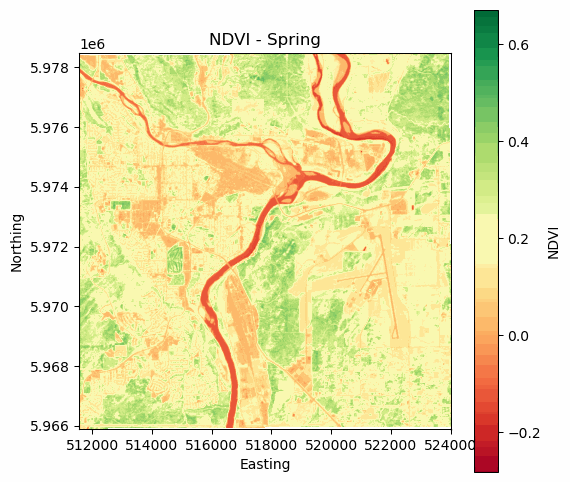

In [30]:
# Display the GIF inline
display(Image(filename=gif_path))

**Code breakdown:**

Calculate spatial bounds using raster dimensions and affine transform:
- `ndvi.shape` provides the number of rows and columns (height and width) of the NDVI array which are stored to variables `nrows` and `ncols`.
- `array_bounds(nrows, ncols, affine)` calculates the coordinates of the four edges (left, bottom, right, top) using the affine transformation.

Save figure to a bytes buffer:
- A `BytesIO` buffer is created to temporarily hold the image data.
- `plt.savefig(buf, format='png', bbox_inches='tight')` saves the figure to the buffer in PNG format.
- `buf.seek(0)` resets the buffer's pointer to the beginning, so the image can be read from the start.

Read the image from the buffer and add to frames:
- `imageio.imread(buf)` reads the image from the buffer.
- In a loop that generates multiple figures, utiziling `plt.close(fig)` to close each figure prevents excessive memory use and ensures that previous figures do not interfere with subsequent ones.

Save the frames as an animated GIF:
- `imageio.mimsave(gif_path, frames, duration=1000, loop=0)` writes the GIF:
    - `frames` is the list of image frames.
    - `duration=1000` sets the display time for each frame in milliseconds.
    - `loop=0` makes the GIF loop infinitely.

# End of Lab 7